# Marco Esparza, Midsemester Project

This project was completed under the instruction and guidance of Dr. Hy Trac of Carnegie Mellon University for the course 33-241: Introduction to Computational Physics.

In [1]:
# matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

# NumPy
import numpy as np
from numpy import pi, sin, sqrt
import numpy.polynomial.legendre as legendre

# SciPy
import scipy
import scipy.linalg as linalg
import scipy.interpolate as interpolate
import scipy.integrate as integrate
import scipy.optimize as opt

In [2]:
## Constants 

l = 1.496e11          # 1 Astronomical Unit
rSun_mks = 4.492e5
rSun = rSun_mks / l   # Distance b/w Sun and COM in Astronomical Units
rEarth = 1 - rSun
epsilon = 10e-10


In [3]:
## Useful Functions

def almostEqual(a, b, error):
    if abs(b - a) <= error:
        return True
    else:
        return False
    
def forwDiff_1D(f, x, h):        # Forward Difference in 1D
    return ( f(x+h) - f(x) ) / h

def backDiff_1D(f, x, h):
    return (f(x) - f(x-h)) / h

def CD_deriv_1D(f, x, h):   # Central Difference of a known function in 1D
    return (f(x+h) - f(x-h)) / h

def partialXDer(f, x, y, h):
    return ( f(x + h/2, y) - f(x - h/2, y) ) / h

def partialYDer(f, x, y, h):
    return ( f(x, y + h/2) - f(x, y - h/2) ) / h

def magn(x, y):
    return np.sqrt(x**2 + y**2)

def magnSq(x, y):
    return x**2 + 3*y**2

def testJacobian(x, y):
    return 7*x + 5*y

def Jacobian2D(f1, f2, x, y, h):
    J = np.zeros((2, 2))      # The Jacobian Matrix
    J[0, 0], J[0, 1] = partialXDer(f1, x, y, h), partialYDer(f1, x, y, h)
    J[1, 0], J[1, 1] = partialXDer(f2, x, y, h), partialYDer(f2, x, y, h)
    det = J[0, 0]*J[1, 1] - J[0, 1]*J[1, 0]
    return J, det         # The Jacobian matrix & its determinant


def partialPivot(A, b):
    N = len(A)
    for m in range(N):
        diagElem = A[m, m]          # Get the diagonal element
        topRow = np.copy(A[m])
        topbElem = float(b[m])
        for i in range(m+1, N):
            currRow = np.copy(A[i])
            currB = float(b[i])
            elemBelow = A[i, m]         # All the elements below divided
                                        # by the respective diagonal element
            if abs(diagElem) < abs(elemBelow):
                A[m], A[i] =  currRow, topRow # Swap the rows
                b[m], b[i] = currB, topbElem
                break
    return A, b


def gaussElim(startA, startB):   # From HW5
    N = len(startB)
    A, b = partialPivot(startA, startB)

    # Gaussian elimination
    for m in range(N):

        # Divide by the diagonal element
        div = A[m,m]
        A[m,:] /= div
        b[m] /= div

        # Now subtract from the lower rows
        for i in range(m+1,N):
            mult = A[i,m]
            A[i,:] -= mult*A[m,:]
            b[i] -= mult*b[m]

    # Backsubstitution
    x = np.empty(N,float)
    for m in range(N-1,-1,-1):
        x[m] = b[m]
        for i in range(m+1,N):
            x[m] -= A[m,i]*x[i]
    return x






## Earth-Sun System

(-1.5, 1.5)

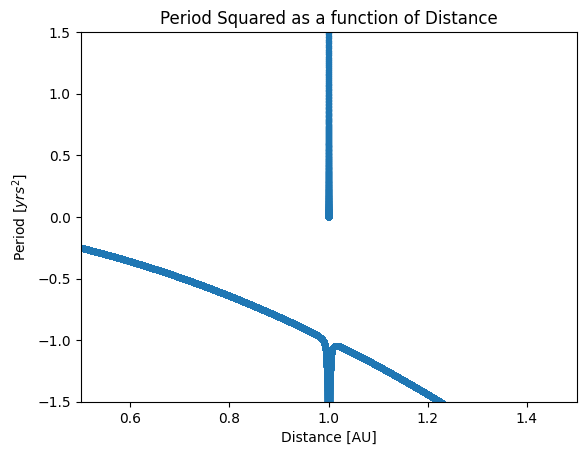

In [4]:
G = 4*pi**2                      # Newton's Gravitational Constant in AU^3 M_sun^-1 yr**-2
M_earthKg = 5.972*10**24         # Mass of Earth in kg
Mearth = M_earthKg / (1.989e30)
distances = np.linspace(-2, 2, 1000000)
Mtot = 1 + Mearth


def P_Sq(x):
    const = 4*pi**2 / G
    numtrSq = (x + rSun)**2 * (rEarth - x)**2
    denomSq = Mearth*(x+rSun)**2 - (rEarth - x)**2
    return const * (numtrSq)/(denomSq)

plt.plot(distances, P_Sq(distances), ".")
plt.xlabel("Distance [AU]")
plt.ylabel("Period [$yrs^{2}$]")
plt.title("Period Squared as a function of Distance")
plt.xlim(0.5, 1.5)
plt.ylim(-1.5, 1.5)

# The Lagrange Points are suggested where yrs^2 = 1, and one of these
#    points has a valid negative solution

## Earth-Sun System Continued

Text(0.5, 1.0, 'Period Squared as a function of x & y')

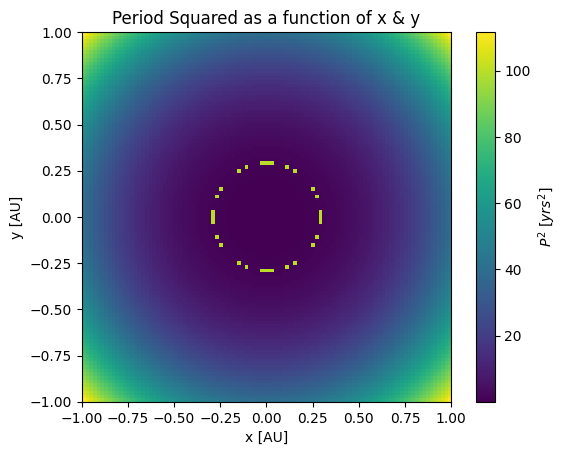

In [5]:
N = 100
l, r = -1, 1
b, t = -1, 1
xVals2D = np.linspace(l, r, N)
yVals2D = np.linspace(b, t, N)

def fxNet(x, y):
    x_s = np.sqrt((x + rSun)**2 + y**2)
    x_e = np.sqrt((-rEarth+x)**2 + y**2)
    f1 = -(rEarth/x_s**3)*(x + rSun) + (rSun/x_e**3)*(rEarth - x)
    return f1

def fyNet(x, y):
    x_s = np.sqrt((x + rSun)**2 + y**2)
    x_e = np.sqrt((rEarth-x)**2 + y**2)
    f2 = -(rEarth/x_s**3)*y - (rSun/x_e**3)*y
    return f2


def P_sq2D(x, y):
    const = 4*pi**2
    r = magn(x, y)
    f = magn(fxNet(x, y), fyNet(x, y))
    return const * (r/f)

def createSpace(xVals, yVals):
    N = len(xVals)
    A = np.zeros((N, N))
    
    for i in range(N):
        for j in range(N):
            x = xVals[j]
            y = yVals[i]
            if 0.99 <= P_sq2D(x, y) <= 1.01:
                A[i, j] = 100    # Values near 1 given max value to suggest
            else:                #   where a period of ~1 year could be
                A[i, j] = P_sq2D(x, y)
    return A

visual2D = createSpace(xVals2D, yVals2D)
plt.imshow(visual2D, extent = [l, r, b, t])
plt.colorbar().set_label("$P^{2}$ [$yrs^2$]")
plt.xlabel("x [AU]")
plt.ylabel("y [AU]")
plt.title("Period Squared as a function of x & y")

## Lagrange Point $L_1$
Method Used: Bisection

SciPy Root: 0.009969512820102683
My L1 Root: 0.009969512754741082


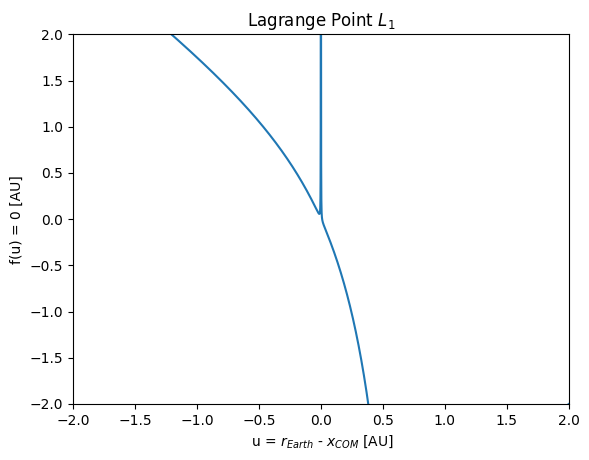

In [6]:
def L1(u):  # From Lecture
    return (rEarth-u) - rEarth/(1 - u)**2 + rSun/u**2

testVals = np.linspace(-25, 25, 100000)
plt.plot(testVals, L1(testVals))
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.title("Lagrange Point $L_1$")
plt.ylabel("f(u) = 0 [AU]")
plt.xlabel(" u = $r_{Earth}$ - $x_{COM}$ [AU]")


def bisect(f, x1, x2):
    if f(x1)*f(x2) > 0:
        return "Must have opposite signs"
    
    mid = (1/2)*(x1 + x2)            # mid = midpoint
    while abs(x1 - x2) > epsilon:
        if f(mid)*f(x1) > 0:
            x1 = mid
        elif f(mid)*f(x2) > 0:
            x2 = mid
        mid = (1/2)*(x1 + x2)
    return mid

L1_leftRoot = opt.bisect(L1, 0.1, 0.0001)
myRootL1 = bisect(L1, 0.1, 10e-12)
print(f"SciPy Root: {L1_leftRoot}")
print(f"My L1 Root: {myRootL1}")


## Lagrange Point $L_2$
Method Used: Method of False Position

SciPy Root: 0.010036218126760676
My L2 Root: 0.010036218237006794


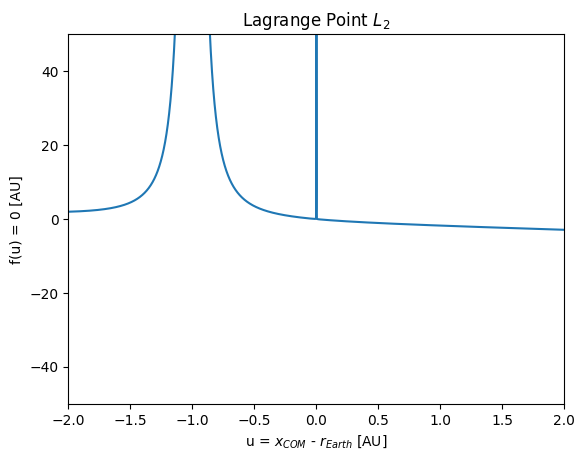

In [7]:
def L2(u):
    return -(rEarth + u) + rEarth/(1+u)**2 + rSun/u**2

testValsL2 = np.linspace(-20, 20, 100000)
plt.plot(testValsL2, L2(testValsL2))
plt.xlim(-2, 2)
plt.ylim(-50, 50)
plt.title("Lagrange Point $L_2$")
plt.ylabel("f(u) = 0 [AU]")
plt.xlabel("u = $x_{COM}$ - $r_{Earth}$ [AU]")


def falsePosition(f, x1, x2):   # x1 and x2 are our initial guesses
    if f(x1)*f(x2) >= 0:
        return "Must have opposite signs"
    
    xInt = x2 - (f(x2)*(x2 - x1) /(f(x2) - f(x1)) )  # x-intercept
    N = 0
    while abs(f(xInt)) > epsilon and N < 100000:
        if f(xInt)*f(x1) > 0:
            x1 = xInt
        elif f(xInt)*f(x2) > 0:
            x2 = xInt
        xInt = x2 - (f(x2)*(x2 - x1) /(f(x2) - f(x1)) )
        N += 1
    return xInt


L2_root = opt.brentq(L2, 0.75, epsilon)
myRootL2 = falsePosition(L2, 0.001, 0.1)  # Must be approximately linear
                                          #  to converge properly
print(f"SciPy Root: {L2_root}")
print(f"My L2 Root: {myRootL2}")


## Lagrange Point $L_3$

Scipy Root: -0.010033871700599469
 My Root:   -0.010033871673162496


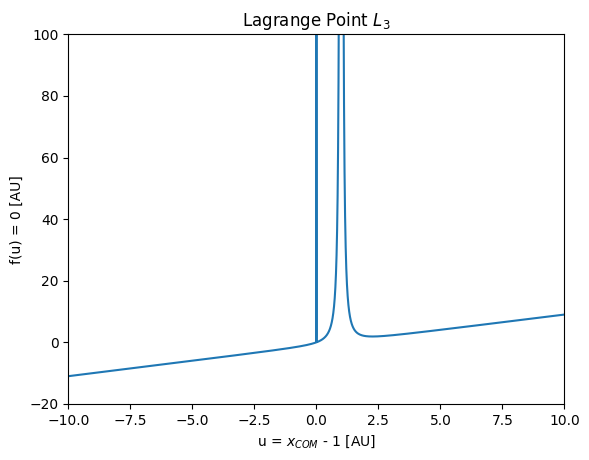

In [8]:
def L3(u):
    return (u - 1) + rEarth/(u-1)**2 + rSun/(u-rSun)**2


testValsL3 = np.linspace(-25, 25, 1000000)
plt.plot(testValsL3, L3(testValsL3))
alpha, beta = 10, 50
plt.xlim(-alpha, alpha)
plt.ylim(-20, 100)
plt.title("Lagrange Point $L_3$")
plt.ylabel("f(u) = 0 [AU]")
plt.xlabel("u = $x_{COM}$ - 1 [AU]")



def secantMethod1D(f, x1, x2):   # x1 and x2 are initial guesses
    xPrime = x2 - f(x2) * (x2-x1)/(f(x2) - f(x1))
    N = 0
    while abs(f(xPrime)) >= epsilon and N < 100:
        prev_xPrime = xPrime
        x1 = x2
        x2 = prev_xPrime
        xPrime = x2 - f(x2) * (x2-x1)/(f(x2) - f(x1))
        N += 1
    return xPrime

L3_root = opt.newton(L3, 2.5)
myRootL3 = secantMethod1D(L3, 0.1, epsilon)

print(f"Scipy Root: {L3_root}")
print(f" My Root:   {myRootL3}")

## $L_1, L_2,  L_3$ Description

$L_1$ and $L_2$ are approximately symmetrical with respect to the earth; about 1% the colinear distance between the Earth and the sun. For L1, the forces per unit mass act in opposite directions, so it's easy to see how they balance out at some point in way that gives the same period at some point. 

For L2, this is not the case. Though less intuitive, it's important to remember that this point rotates around the COM, not the Sun itself, so the Earth itself creates a point such that the circular accelaration creates the same period

For L3, the point is about 1 AU from the center of mass, to the direction OPPOSITE to which the Earth is at. Force balancing with accelaration, the Sun absolutely dominates the total mass, and as a result also dominates the distance at which another point would be balanced out.

## Lagrange Point $L_4$


SciPy Root: [0.499997  0.8660254]
  My Root:  [0.49999699 0.86602541]


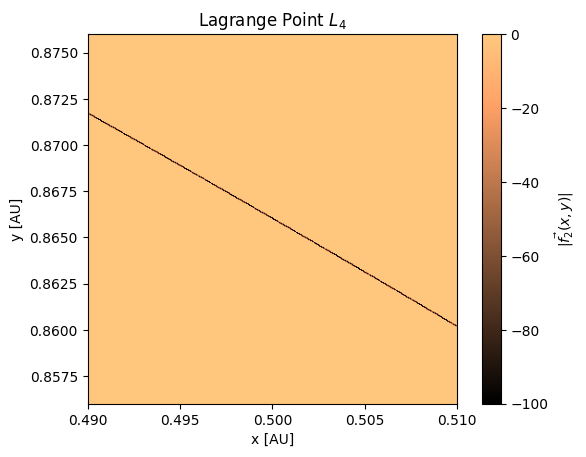

In [9]:
N_L4 = 400
sq = 1
xLeft, xRight = 0.49, 0.51
yBottom, yTop = 0.856, 0.876
xValsL4 = np.linspace(xLeft, xRight, N_L4)
yValsL4 = np.linspace(yBottom, yTop, N_L4)

# System of Equations
def L4x(x, y):
    x_s = np.sqrt((x + rSun)**2 + y**2)
    x_e = np.sqrt((-rEarth+x)**2 + y**2)
    f1 = -(rEarth/x_s**3)*(x + rSun) + (rSun/x_e**3)*(rEarth - x) + x
    return f1

def L4y(x, y):
    x_s = np.sqrt((x + rSun)**2 + y**2)
    x_e = np.sqrt((rEarth-x)**2 + y**2)
    f2 = -(rEarth/x_s**3)*y - (rSun/x_e**3)*y + y
    return f2


def visualMtxL4(xVals, yVals, f1, f2):
    xyMtx = [["" for betaL4 in range(N_L4)] for alphaL4 in range(N_L4)]
    fMtx = np.zeros((N_L4, N_L4), float)
    N = len(xVals)
    for i in range(N_L4):
        for j in range(N_L4):
            x, y = xVals[j], yVals[i]
            xyMtx[i][j] = f"{float(x), float(y)} = {float(magn(f1(x, y), f2(x, y)))}"
            
            if 0.01 <= magn(f1(x, y), f2(x, y)) <= 100:
                fMtx[i, j] = magn(f1(x, y), f2(x, y))
            elif magn(f1(x, y), f2(x, y)) > 100:       # Brightness Capped
                fMtx[i, j] = 101
            elif magn(f1(x, y), f2(x, y)) < 0.0001:    # Set to darkest Value to highlight possible zeros
                fMtx[i, j] = -100                      # Ideally, we would keep setting this value lower and lower until epsilon
                                                       #     but it's set to this value for the sake of demonstration
    return fMtx


visual = visualMtxL4(xValsL4, yValsL4, L4x, L4y)
plt.imshow(visual, cmap="copper",  origin="lower",  extent=[xLeft, xRight, yBottom, yTop])
plt.colorbar().set_label(r"|$\vec{f_2} (x, y)$|")
plt.title("Lagrange Point $L_4$")
plt.xlabel("x [AU]")
plt.ylabel("y [AU]")

def systemL4(rComps):
    x, y = rComps
    return [L4x(x, y), L4y(x,y)]


def newtonRaphson2D(f1, f2, x1, y1):   # 2D Function with initial guesses
    r = np.array([x1, y1])
    f = np.array([f1(x1, y1), f2(x1, y1)])
    J, Jdet = Jacobian2D(f1, f2, x1, y1, epsilon)
    Delta_r = gaussElim(J, f)
    rPrime = r - Delta_r

    N = 0
    while magn(f1(x1, y1), f2(x1, y1)) > epsilon:
        prev_rPrime = rPrime
        x1, y1 = rPrime[0], rPrime[1]
        f = np.array([f1(x1, y1), f2(x1, y1)])
        J, Jdet = Jacobian2D(f1, f2, x1, y1, epsilon)
        Delta_r = gaussElim(J, f)
        rPrime = prev_rPrime - Delta_r
        N += 1
    return rPrime

myRootL4 = newtonRaphson2D(L4x, L4y, 0.3 , 0.8)
L4_root = opt.root(systemL4, [0.49, 0.84])
print(f"SciPy Root: {L4_root.x}")
print(f"  My Root:  {myRootL4}")


## Lagrange Point $L_5$

 My Root:   [ 0.49999701 -0.8660254 ] 
SciPy Root: [ 0.499997  -0.8660254]


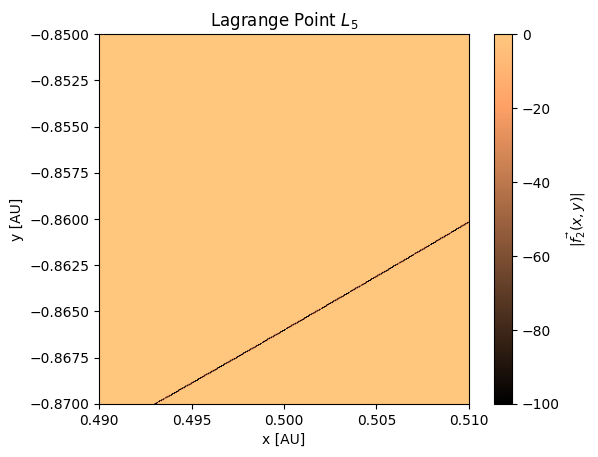

In [10]:
N_L5 = 400
sq = 1.5
xLeftL5, xRightL5 = 0.49, 0.51
yBottomL5, yTopL5 = -0.85,-0.87
xValsL5 = np.linspace(xLeftL5, xRightL5, N_L5)
yValsL5 = np.linspace(yBottomL5, yTopL5, N_L5)

# System of Equations
def L5x(x, y):
    x_s = np.sqrt((x + rSun)**2 + y**2)
    x_e = np.sqrt((-rEarth+x)**2 + y**2)
    f1 = -(rEarth/x_s**3)*(x + rSun) + (rSun/x_e**3)*(rEarth - x) + x
    return f1


def L5y(x, y):
    x_s = np.sqrt((x + rSun)**2 + y**2)
    x_e = np.sqrt((rEarth-x)**2 + y**2)
    f2 = +(rEarth/x_s**3)*y + (rSun/x_e**3)*y - y
    return f2

def systemL5(rComps):
    x, y = rComps
    return [L5x(x, y), L5y(x,y)]


def visualMtxL5(xVals, yVals, f1, f2):
    fMtx = np.zeros((N_L5, N_L5), float)
    N = len(xVals)
    for i in range(N_L5):
        for j in range(N_L5):
            x, y = xVals[j], yVals[i]
            
            if 0.01 <= magn(f1(x, y), f2(x, y)) <= 100:
                fMtx[i, j] = magn(f1(x, y), f2(x, y))
            elif magn(f1(x, y), f2(x, y)) > 100:
                fMtx[i, j] = 101
            elif magn(f1(x, y), f2(x, y)) < 0.0001: 
                fMtx[i, j] = -100
    return fMtx

visual = visualMtxL5(xValsL5, yValsL5, L5x, L5y)
plt.imshow(visual, cmap="copper",  origin="lower",  extent=[xLeftL5, xRightL5, yBottomL5, yTopL5])
plt.colorbar().set_label(r"|$\vec{f_2} (x, y)$|")
plt.title("Lagrange Point $L_5$")
plt.xlabel("x [AU]")
plt.ylabel("y [AU]")
plt.xlim(0.49, 0.51)
plt.ylim(-0.87, -0.85)



L5_root = opt.root(systemL5, [0.48, -0.84])
myRootL5 = newtonRaphson2D(L5x, L5y, 0.3 , -0.92)
print(f" My Root:   {myRootL5} ")
print(f"SciPy Root: {L5_root.x}")


## $L_4$ and $L_5$ Zoomed out

Text(0, 0.5, 'y [AU]')

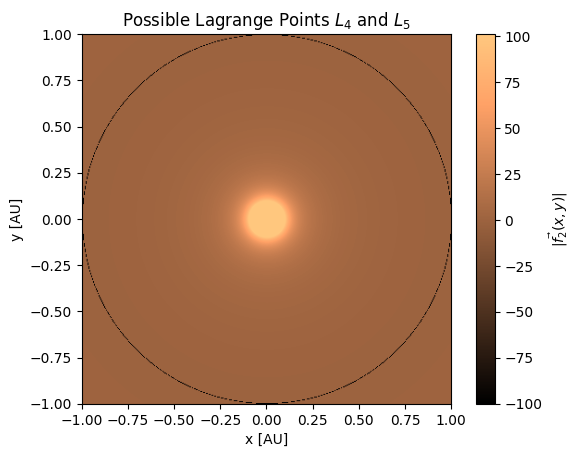

In [11]:
xZout = np.linspace(-1, 1, 400)
yZout = np.linspace(-1, 1, 400)

def visualMtxZout(xVals, yVals, f1, f2):
    xyMtx = [["" for betaL4 in range(N_L4)] for alphaL4 in range(N_L4)]
    fMtx = np.zeros((N_L4, N_L4), float)
    N = len(xVals)
    for i in range(N_L4):
        for j in range(N_L4):
            x, y = xVals[j], yVals[i]
            xyMtx[i][j] = f"{float(x), float(y)} = {float(magn(f1(x, y), f2(x, y)))}"
            

            if 0.01 <= magn(f1(x, y), f2(x, y)) <= 100:
                fMtx[i, j] = magn(f1(x, y), f2(x, y))
            elif magn(f1(x, y), f2(x, y)) > 100:       # Function blows up to inf here
                fMtx[i, j] = 101                       #     so I cap the brightness here at 101
            elif magn(f1(x, y), f2(x, y)) < 0.005:     # Set possibles zeros to 
                fMtx[i, j] = -100                      #     darkest values
    return fMtx

visualZout = visualMtxZout(xZout, yZout, L4x, L4y)
plt.imshow(visualZout, cmap="copper",  origin="lower",  extent=[-1, 1, -1, 1])
plt.colorbar().set_label(r"|$\vec{f_2} (x, y)$|")
plt.title("Possible Lagrange Points $L_4$ and $L_5$")
plt.xlabel("x [AU]")
plt.ylabel("y [AU]")

## $L_4$ and $L_5$ Description

The $L_4$ and $L_5$ Lagrange point components correspond to the sine and cosine values of $\theta \approx 60\degree $. Since these points must co-rotate with the Earth, their period must be the same as Earth; using Newton's Second Law and assuming a circular orbit, the analytical x value turns out to be $x = \frac{1}{2}(r_{Earth} - r_{Sun})$ from the COM, but since $r_{Earth}$ >> $r_{Sun}$ it about halfway in practice. Furthermore, it turns out that $L_4$ and $L_5$ have exactly equidistant x AND y components from the Earth & Sun, 0.5 AU and $\sqrt{3}/2$ AU (assuming a circular orbit). 

A deeper analysis would likely use an elliptical orbit with a transverse accelaration, the fact that Earth is a non-inertial reference frame, and the contribution from other celestial bodies. 

## Model
Model to verify that locations appear consisent with what was shown in class

Text(0.5, 1.0, 'Earth-Sun Visualized')

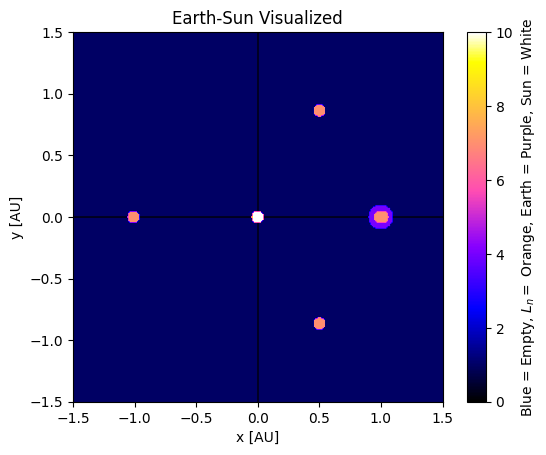

In [12]:
left, right = -1.5, 1.5
bottom, top = -1.5, 1.5
M_vis, N_vis = 301, 301

rSunScaled = 0.1
rEarthScaled = 0.9

xBlank = np.linspace(left, right, M_vis)
yBlank = np.linspace(bottom, top, N_vis)
#print(xBlank)


LagrangePoints = [np.array([myRootL1, 0]), np.array([myRootL2, 0]),  
                np.array([myRootL3, 0]), myRootL4, myRootL5]

def create(xVals, yVals, LgPts):
    sunVec = np.array([-rSun, 0])
    earthVec = np.array([rEarth, 0])
    L1vec = np.array([rEarth - myRootL1, 0])
    L2vec = np.array([rEarth + myRootL2, 0])
    L3vec = np.array([-1 + myRootL3, 0])
    L4vec = np.array(myRootL4)
    L5vec = np.array(myRootL5)

    N = len(xBlank)
    A = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            x = xBlank[j]
            y = yBlank[i]
            rVec, rMagn = np.array([x, y]), magn(x, y)


            if magn((sunVec - rVec)[0], (sunVec - rVec)[1]) <= 0.05:
                A[i, j] = 10

            elif magn((L1vec - rVec)[0], (L1vec - rVec)[1]) <= 0.05:
                A[i, j] = 7
            elif magn((L2vec - rVec)[0], (L2vec - rVec)[1]) <= 0.05:
                A[i, j] = 7
            elif magn((earthVec - rVec)[0], (earthVec - rVec)[1]) <= 0.1:
                A[i, j] = 4
            elif magn((L3vec - rVec)[0], (L3vec - rVec)[1]) <= 0.05:
                A[i, j] = 7
            elif magn((L4vec - rVec)[0], (L4vec - rVec)[1]) <= 0.05:
                A[i, j] = 7
            elif magn((L5vec - rVec)[0], (L5vec - rVec)[1]) <= 0.05:
                A[i, j] = 7
            elif almostEqual(y, 0, epsilon):
                A[i, j] = 0
            elif almostEqual(x, 0, epsilon):
                A[i, j] = 0
            else:
                A[i, j] = 1
    return A

blank = create(xBlank, yBlank, LagrangePoints)
#print(blank)

plt.imshow(blank, origin="lower", cmap="gnuplot2", extent=[left, right, bottom, top])
plt.colorbar().set_label("Blue = Empty, $L_n=$ Orange, Earth = Purple, Sun = White")
plt.xlabel("x [AU]")
plt.ylabel("y [AU]")
plt.title("Earth-Sun Visualized")

# Earth is Enlarged for Clarity

## Indepedent Component
If we could easily get past the earth in a colinear path, which lagrange point requires less energy to get to? We'll do this using Integration via Gaussian Quadrature

-10.387778139415692


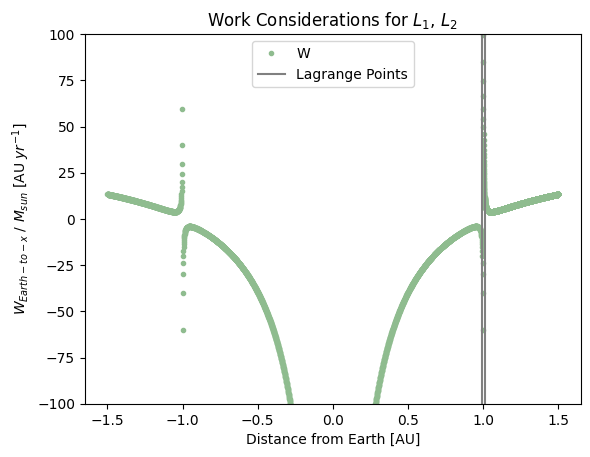

In [13]:


def L1_fNet(x):  # Force in Msun * AU * yr^(-2) for a UNIT mass
    return - (G /(x + rSun)**2 + G*Mearth/(rEarth-x)**2)

def L2_fNet(x):
    return - (G/(x + rSun)**2 - G*Mearth/(x-rEarth)**2)


def findIntg(integrand, alpha, beta, N):
    x,w = legendre.leggauss(N)
    xp = 0.5*(beta-alpha)*x + 0.5*(beta+alpha)
    wp = 0.5*(beta-alpha)*w
    I = np.sum(wp*integrand(xp))
    return I
 
E_to_x = -findIntg(L1_fNet, rEarth, 1-myRootL1, 20) # Energy in Msun * AU * yr^(-1)
print(E_to_x)

def integralSpace(f, xVals):
    N = len(xVals)
    energies = np.zeros(N)
    for i in range(N):
        x = abs(xVals[i])
        E = -findIntg(f, rEarth, x, 20)
        energies[i] = E
    return energies


leftXspace = np.linspace(-1.5, 1, 3001)
rightXspace = np.linspace(1, 1.5, 3001)
energiesEarthtoL1 = integralSpace(L1_fNet, leftXspace)
energiesEarthtoL2 = integralSpace(L1_fNet, rightXspace)


plt.plot(leftXspace, energiesEarthtoL1, ".", color="darkseagreen", label = "W")
plt.plot(rightXspace, energiesEarthtoL2, ".", color = "darkseagreen")

L1_line = [rEarth-myRootL1 for b in range(-100, 100)]
L2_line = [rEarth+myRootL2 for b in range(-100, 100)]
plt.plot(L1_line, range(-100, 100, 1), color="gray", label = "Lagrange Points")
plt.plot(L2_line, range(-100, 100, 1), color="gray")

plt.ylim(-100, 100)
plt.xlabel("Distance from Earth [AU]")
plt.ylabel("$W_{Earth-to-x}$ / $M_{sun}$ [AU $yr^{-1}$]")
plt.title("Work Considerations for $L_1$, $L_2$")
plt.legend()






With this collinear assumption, it takes slightly less work to get from Earth $L_1$ to than Earth to $L_2$, likely because the force from the sun points in the same direction as L1 relative to the earth. Furthermore, we (inadvertently) found where L3 could be!! Again, a deeper analysis accounts for the work it takes in all 3 dimensions, considering other celestial bodies, and transverse accelaration of the Earth